# Logistic Regression - K-Fold

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

## Original Dataset

In [1]:
# Load Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import ds_functions as ds

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

N_SPLITS = 10

In [2]:
data: pd.DataFrame = pd.read_csv('../../datasets/heart_failure_clinical_records_dataset.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

In [3]:
def kfold_model(X, y, penalty, C, max_iters):
    # Compute the Average metrics and CNFMTX for a set of hyper-parameters
    kf = KFold(n_splits = N_SPLITS, shuffle=True)

    acc = [0, 0]
    recall = [0, 0]
    specificity = [0, 0]
    precision = [0, 0]
    matrices = np.zeros((2, 2, N_SPLITS))
    h = 0

    for train_index, test_index in kf.split(X):
        trnX, tstX = X[train_index], X[test_index]
        trnY, tstY = y[train_index], y[test_index]

        logreg = LogisticRegression(penalty=penalty, C=C, max_iter=max_iters)
        logreg.fit(trnX, trnY)

        prd_trn = logreg.predict(trnX)
        prd_tst = logreg.predict(tstX)

        cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
        tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
        cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
        matrices[:,:,h] = cnf_mtx_tst
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

        acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
        acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)

        recall[0] += tp_trn / (tp_trn + fn_trn)
        recall[1] += tp_tst / (tp_tst + fn_tst)

        specificity[0] += tn_trn / (tn_trn + fp_trn)
        specificity[1] += tn_tst / (tn_tst + fp_tst)

        precision[0] += tp_trn / (tp_trn + fp_trn)
        precision[1] += tp_tst / (tp_tst + fp_tst)

        h += 1


    acc = np.divide(acc, N_SPLITS)
    recall = np.divide(recall, N_SPLITS)
    specificity = np.divide(specificity, N_SPLITS)
    precision = np.divide(precision, N_SPLITS)
    cnf_mtx = np.mean(matrices, axis=2).astype('int64')

    evaluation = {'Accuracy': acc,
                  'Recall': recall,
                  'Specificity': specificity,
                  'Precision': precision}
    
    return evaluation, cnf_mtx

In [4]:
def log_reg_analysis(X, y):
    
    max_acc = -1

    penalty = ['l2', 'none']
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    max_iters = [10, 25, 50, 100, 200]
        
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
    
    for p in penalty:
        
        values = {}
        
        for c in C:
            
            acc_values = []
            
            for max_i in max_iters:
                
                evaluation, cnf_mtx = kfold_model(X, y, p, c, max_i)
                
                acc_values.append(evaluation['Accuracy'][1])
                
                if evaluation['Accuracy'][1] > max_acc:
                                       
                    best_model = (p, c, max_i)
                    best_metrics = evaluation, cnf_mtx
                    max_acc = evaluation['Accuracy'][1]
                    
            values[c] = acc_values
                        
        ds.multiple_line_chart(max_iters, values, ax=axs[0, penalty.index(p)], title='Logistic Regression with %s penalty' % p,
                               xlabel='Maximum Iterations', ylabel='Accuracy', percentage=True, ymin=0.6, ymax=1)

                    
    return best_model, evaluation, cnf_mtx

In [5]:
def pretty_metrics(evaluation):
        
    print('\tModel Statistics\n===============================')

    for k in evaluation.keys():
        line_new = '%12s  %.2f  %.2f' % (k, evaluation[k][0], evaluation[k][1])
        
        print(line_new)
                

<Figure size 600x450 with 0 Axes>

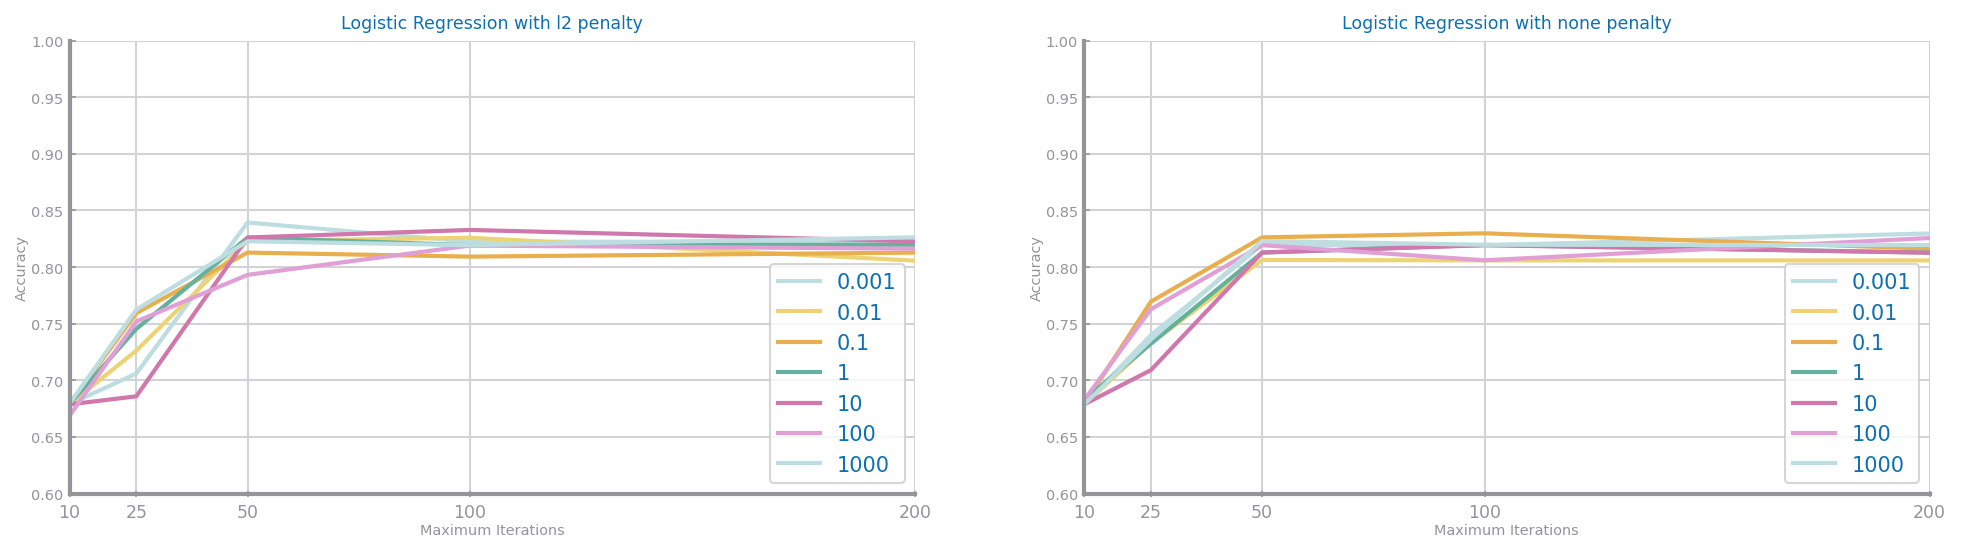

In [6]:
model, evaluation, cnf_mtx = log_reg_analysis(X, y)

	Model Statistics
    Accuracy  0.83  0.82
      Recall  0.65  0.64
 Specificity  0.91  0.90
   Precision  0.78  0.77


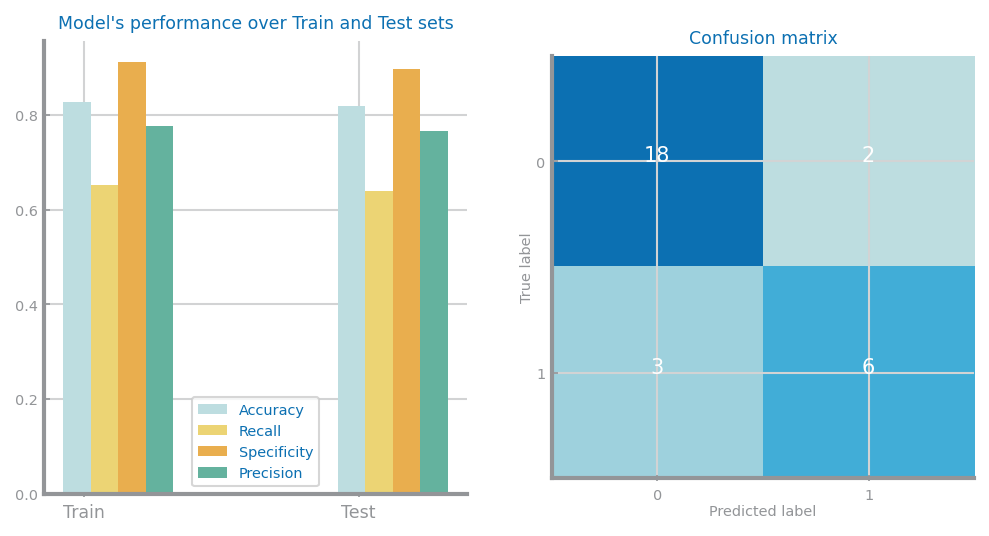

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

pretty_metrics(evaluation)

<br/>
<br/>
<br/>
<br/>
<br/>

## Scaled (Standardized)

In [8]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_scaled/HF_standardized.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

<Figure size 600x450 with 0 Axes>

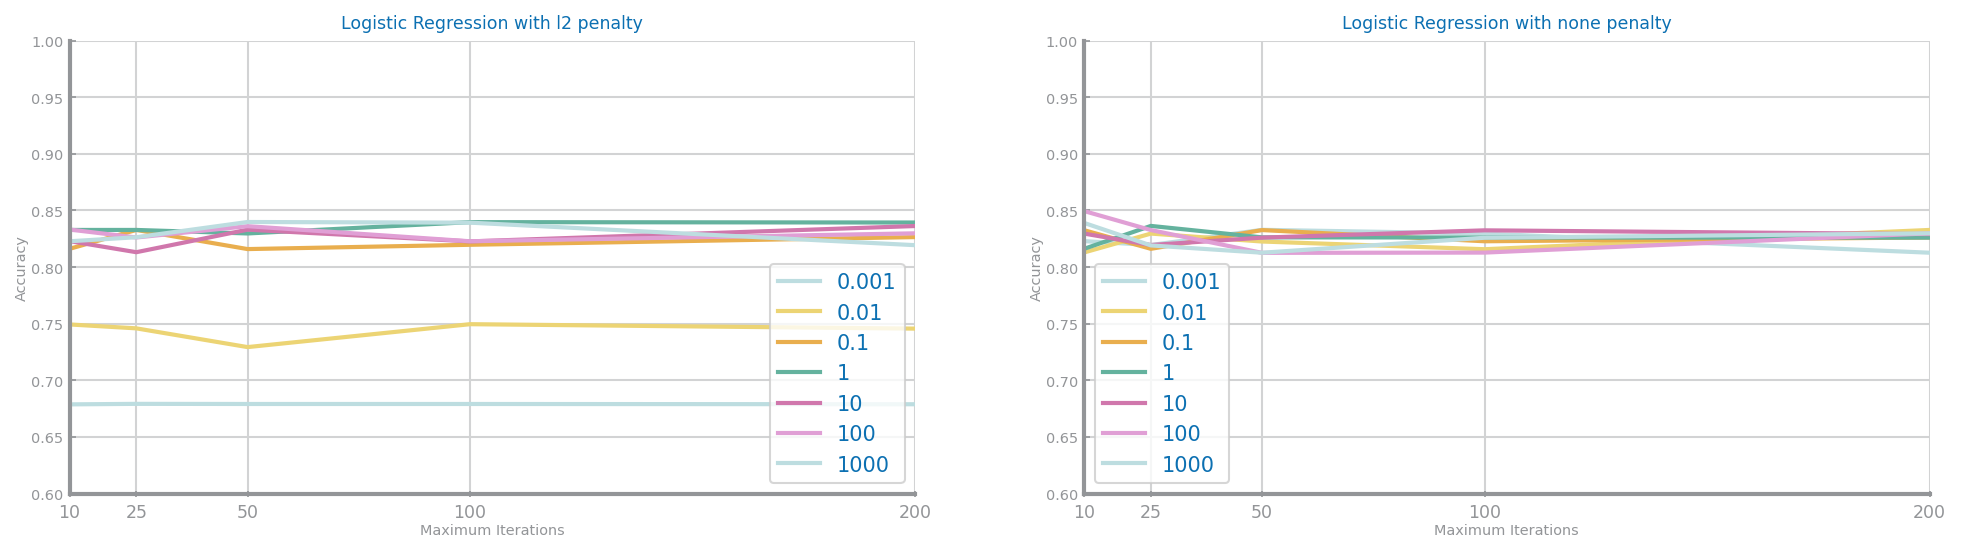

In [9]:
model, evaluation, cnf_mtx = log_reg_analysis(X, y)

	Model Statistics
    Accuracy  0.85  0.83
      Recall  0.71  0.66
 Specificity  0.92  0.90
   Precision  0.81  0.78


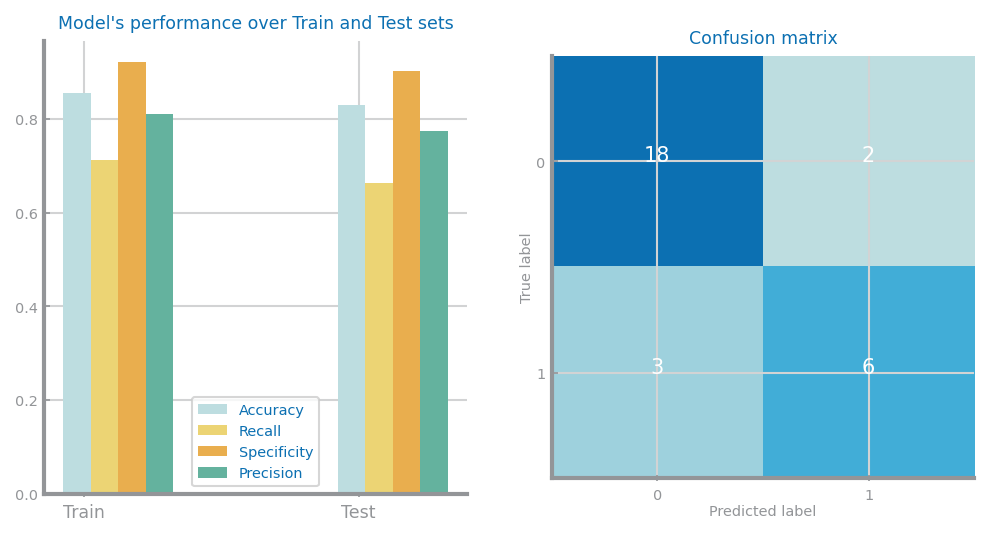

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

pretty_metrics(evaluation)

<br/>
<br/>
<br/>
<br/>
<br/>

## Scaled & Outliers with Windsorization

In [11]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_outliers/HR_S_outlierWins.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

<Figure size 600x450 with 0 Axes>

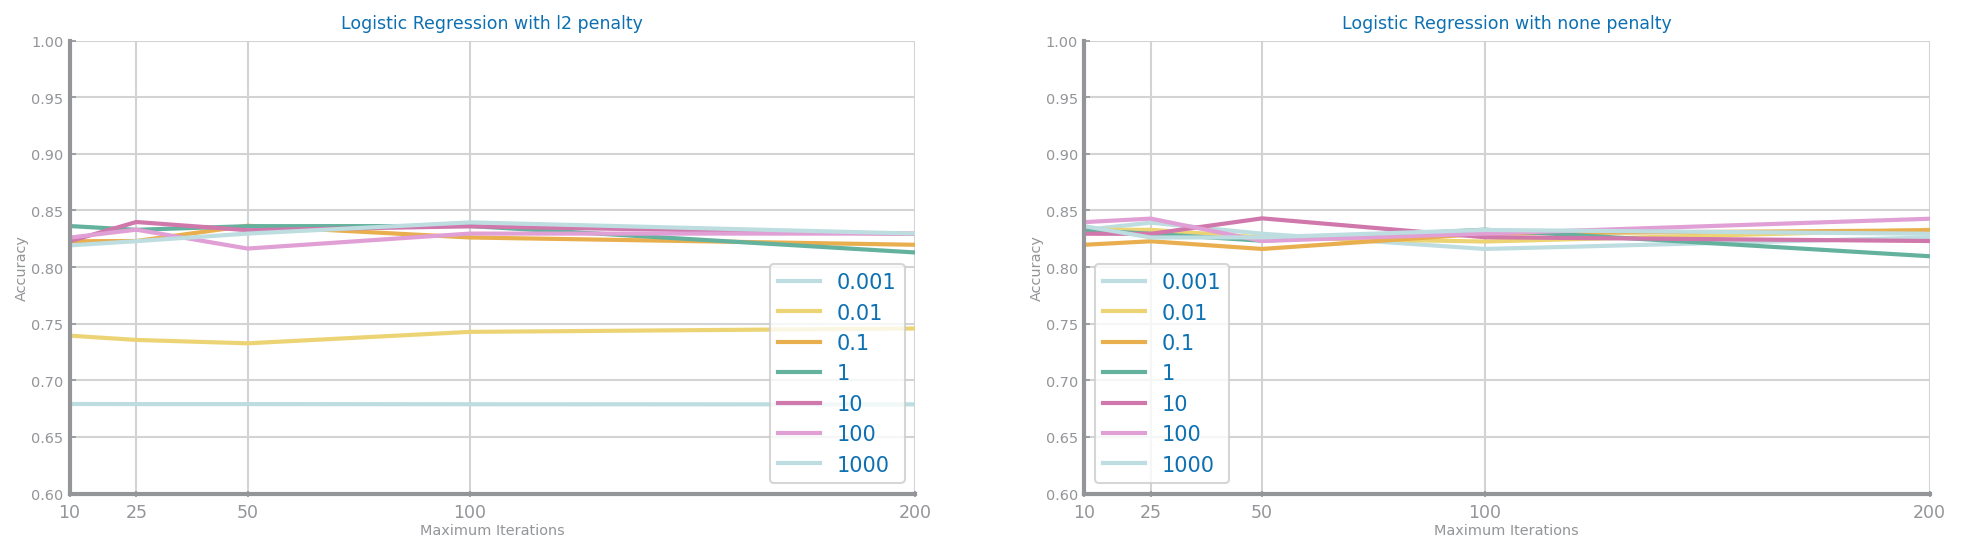

In [12]:
model, evaluation, cnf_mtx = log_reg_analysis(X, y)

	Model Statistics
    Accuracy  0.85  0.83
      Recall  0.72  0.69
 Specificity  0.91  0.89
   Precision  0.80  0.75


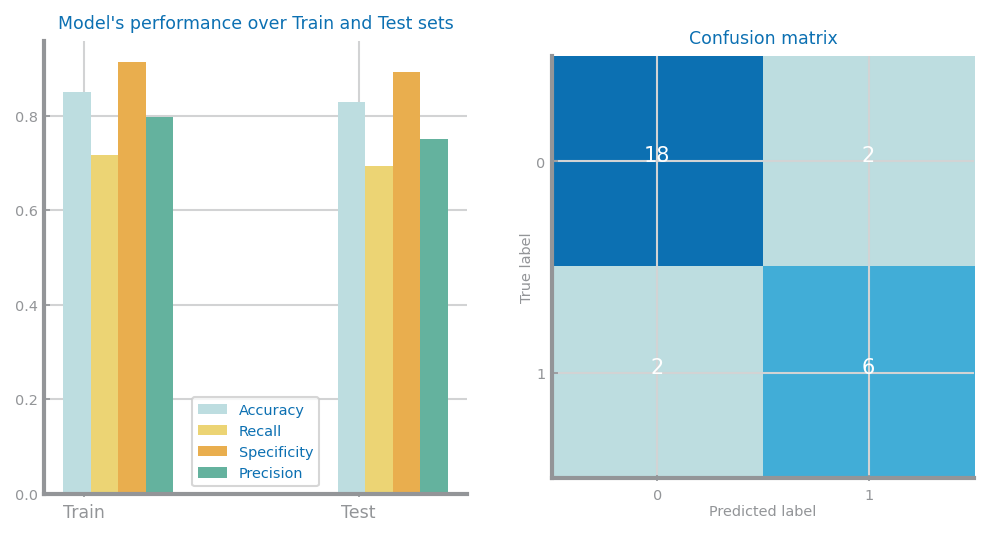

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

pretty_metrics(evaluation)

<br/>
<br/>
<br/>
<br/>
<br/>

## Trimmed Outliers Dataset (Interquartile)

In [14]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_outliers/HR_S_outlierTrim_IQS.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

<Figure size 600x450 with 0 Axes>

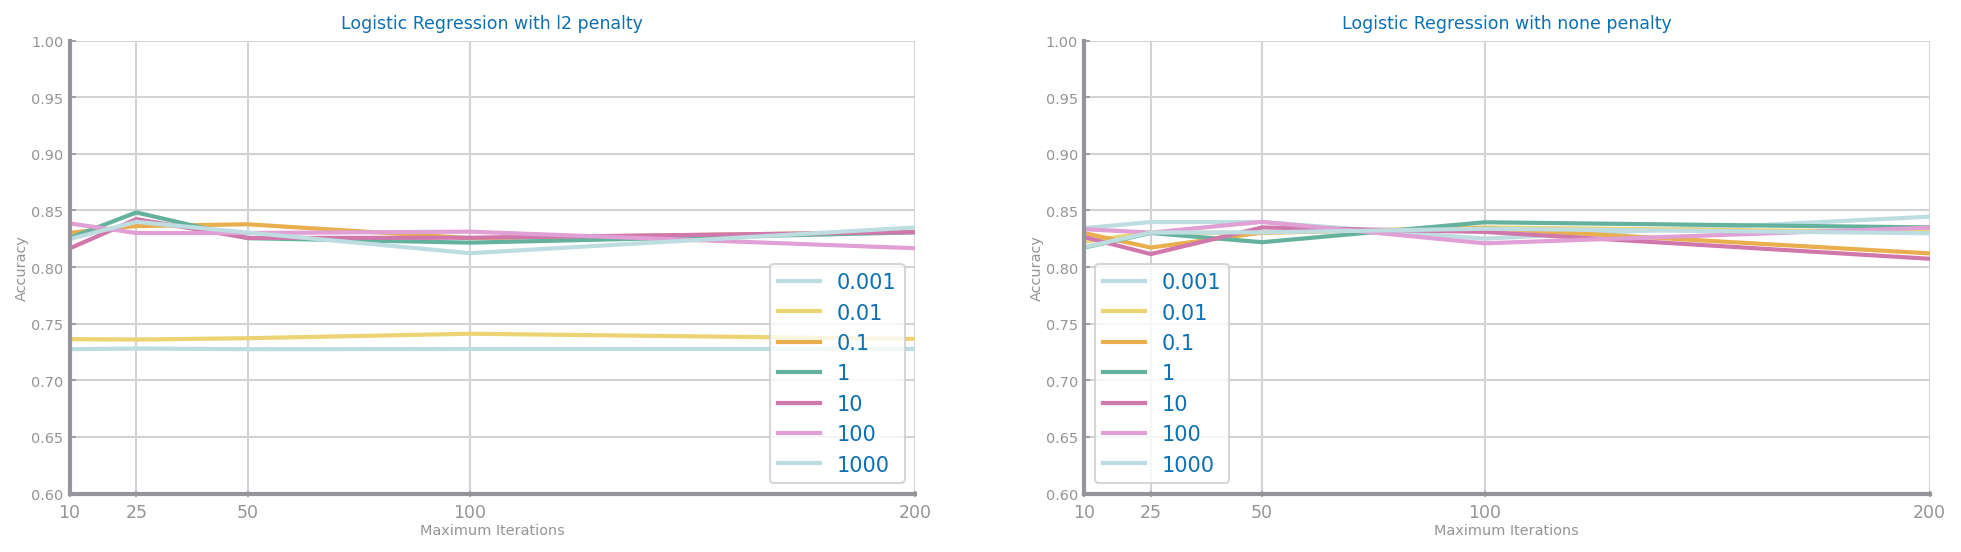

In [15]:
model, evaluation, cnf_mtx = log_reg_analysis(X, y)

	Model Statistics
    Accuracy  0.85  0.83
      Recall  0.66  0.63
 Specificity  0.93  0.91
   Precision  0.77  0.78


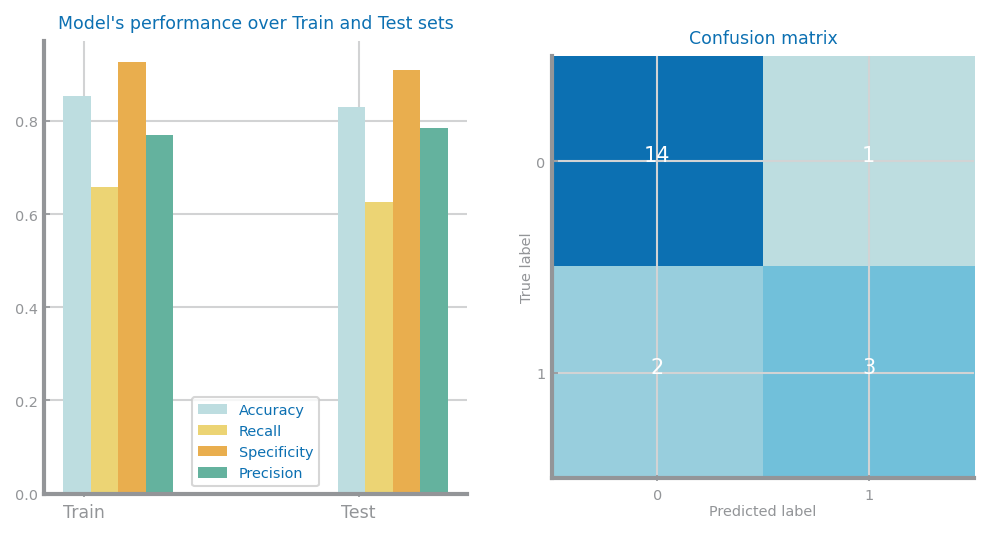

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

pretty_metrics(evaluation)

<br/>
<br/>
<br/>
<br/>
<br/>

## Balanced Dataset

In [17]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_balanced/HF_balanced.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

<Figure size 600x450 with 0 Axes>

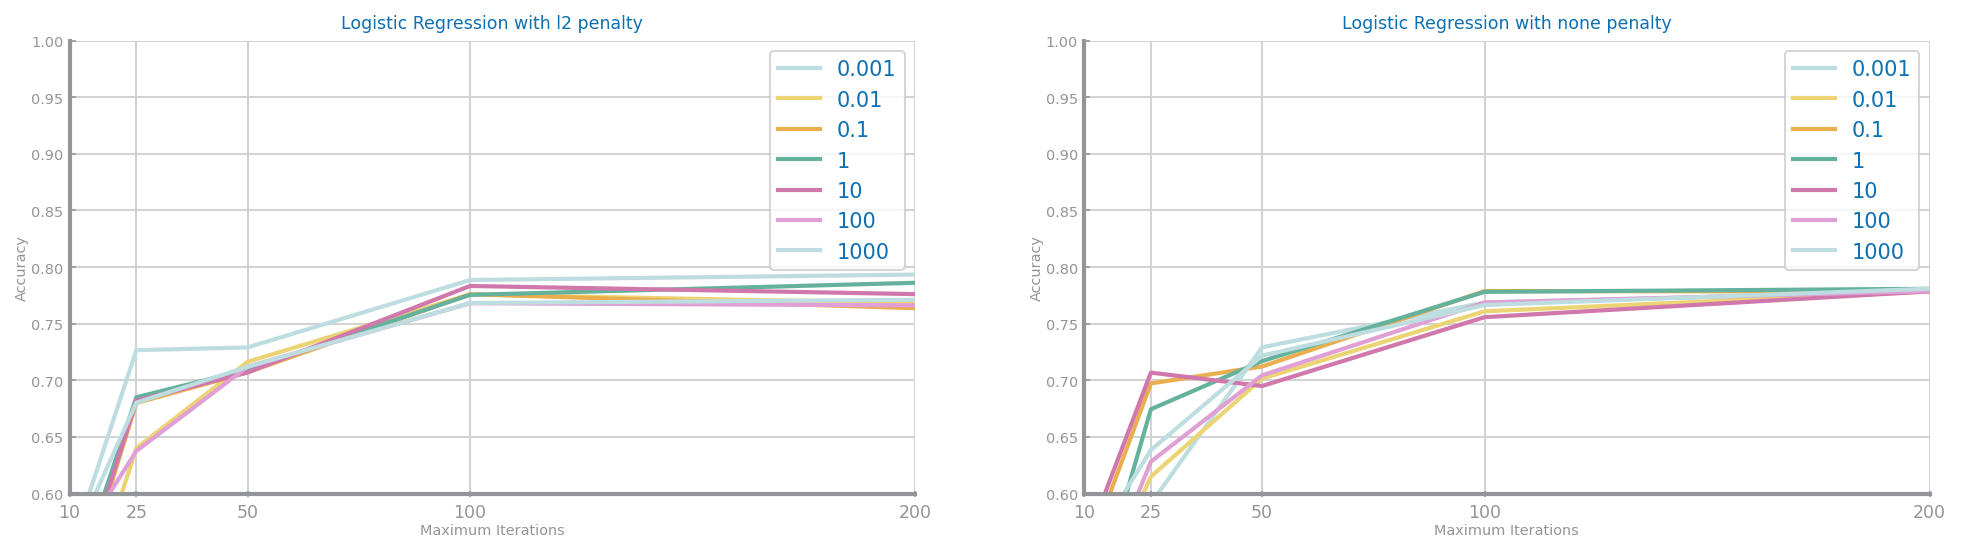

In [18]:
model, evaluation, cnf_mtx = log_reg_analysis(X, y)

	Model Statistics
    Accuracy  0.78  0.78
      Recall  0.78  0.77
 Specificity  0.79  0.79
   Precision  0.79  0.79


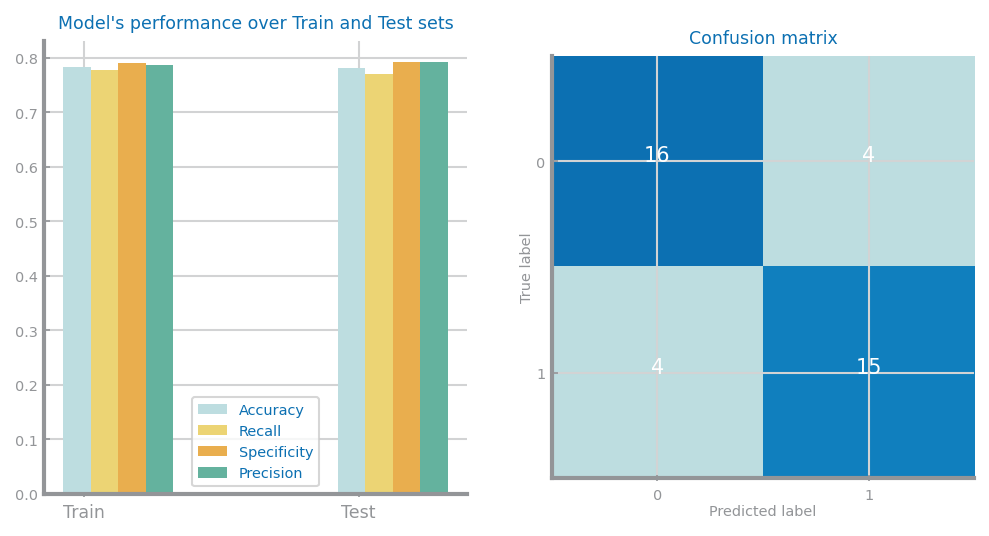

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

pretty_metrics(evaluation)

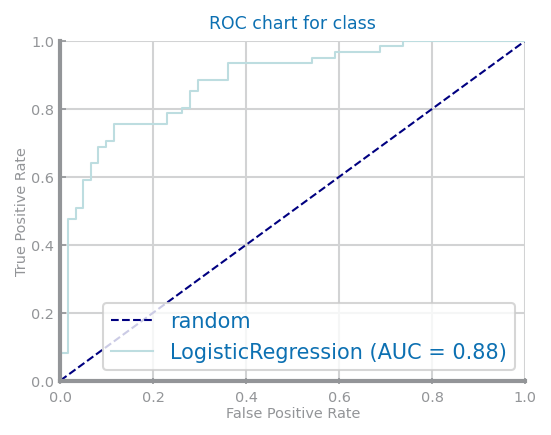

In [20]:
def plot_roc_chart(models: dict, X: np.ndarray, y: np.ndarray, ax: plt.Axes = None, target: str = 'class'):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s' % target)

    ax.plot([0, 1], [0, 1], color='navy', label='random', linewidth=1, linestyle='--',  marker='')
    
    for clf in models.keys():
        trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
        lr = LogisticRegression(penalty=models[clf][0], C=models[clf][1], max_iter=models[clf][2])
        lr.fit(trnX, trnY)
        metrics.plot_roc_curve(lr, tstX, tstY, ax=ax, marker='', linewidth=1)
    ax.legend(loc="lower right")

plt.figure()
plot_roc_chart({'Best LogReg Model': model}, X, y, target='class')
plt.show()

<br/>
<br/>
<br/>
<br/>
<br/>

## Balanced and Standardized Dataset

In [21]:
data: pd.DataFrame = pd.read_csv('../../datasets/HF_balanced_standardized.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

<Figure size 600x450 with 0 Axes>

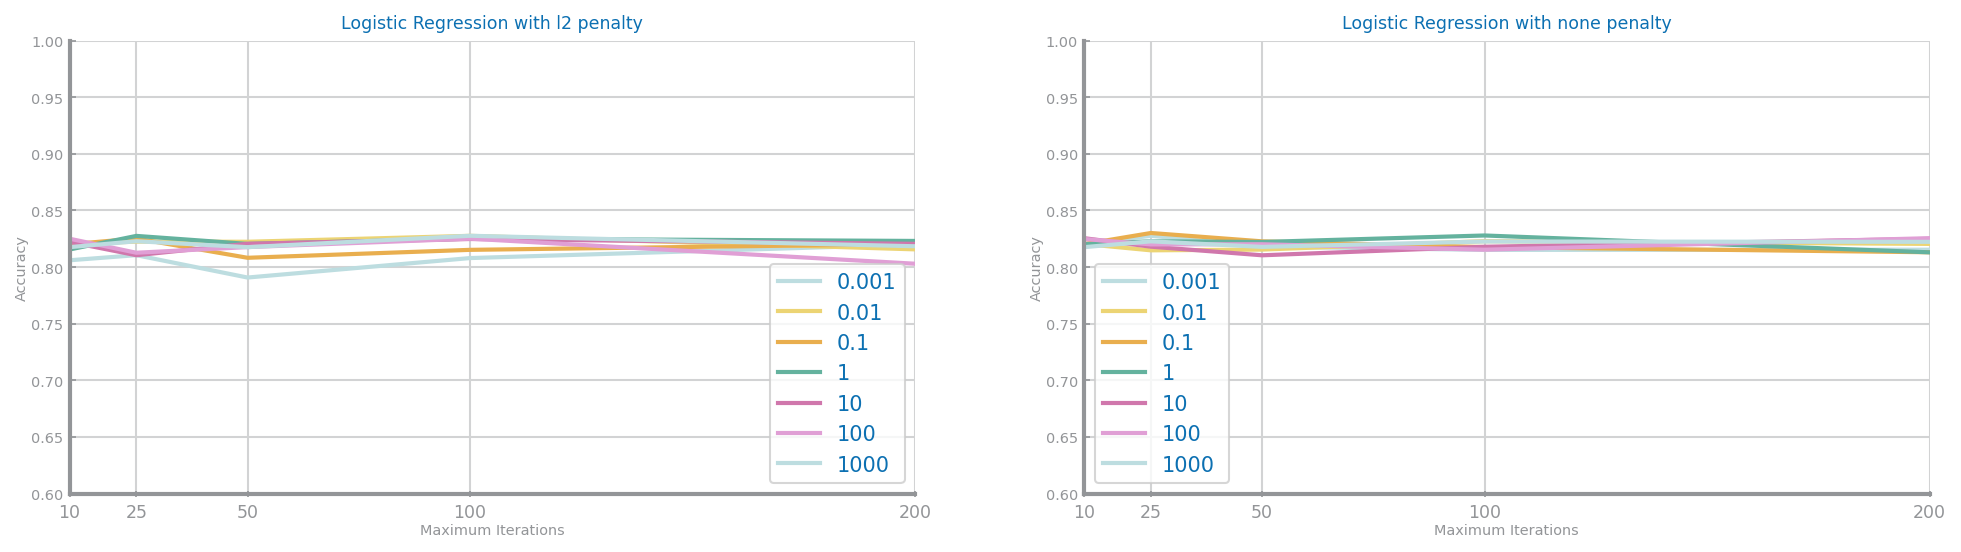

In [22]:
model, evaluation, cnf_mtx = log_reg_analysis(X, y)

	Model Statistics
    Accuracy  0.83  0.82
      Recall  0.83  0.82
 Specificity  0.83  0.82
   Precision  0.83  0.82


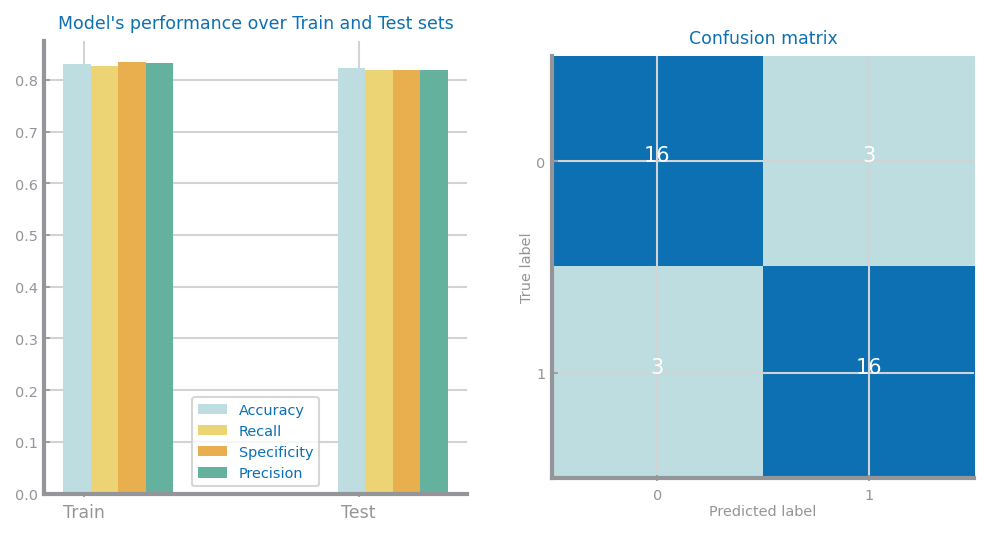

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

pretty_metrics(evaluation)

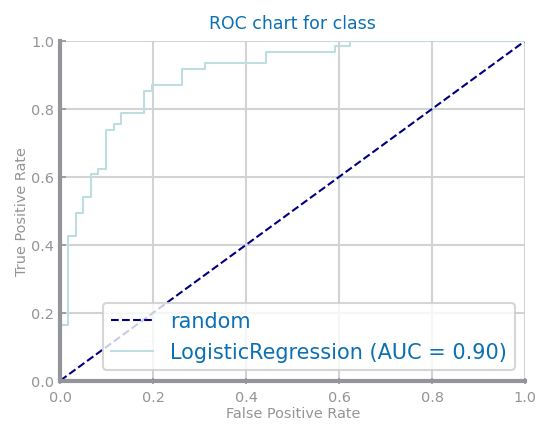

In [24]:
plt.figure()
plot_roc_chart({'Best LogReg Model': model}, X, y, target='class')
plt.show()